In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.spatial import distance
from IPython.display import clear_output, display
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans

import wolff

# Track calculation errors
np.seterr('raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [2]:
def similarity(data, theta, angspace, bin_width):
    num_trials = data.shape[0]
    num_channels = data.shape[1]
    timesteps = data.shape[2]

    # distances.shape: trials by bins by time
    distances = np.empty((num_trials, len(angspace), timesteps))
    # cos_amp.shape: trials by time
    cos_amp = np.empty((num_trials, timesteps))

    for trl in range(0, num_trials):
        clear_output(wait=True)
        display("Trial " + str(trl+1) + "/" + str(num_trials))
        # Get all data except trl
        trn_dat = data[np.arange(num_trials) != trl, :, :]
        # Get all angles except the one associated with trl
        trn_angle = theta[np.arange(num_trials) != trl]
        # m.shape: bins by channels by time
        m = np.empty((len(angspace), num_channels, timesteps))

        # Average the training data into orientation bins relative to the
        # test-trial's orientation
        for b in range(0, len(angspace)):
            angle_dists = np.abs(np.angle(np.exp(1j*trn_angle) / np.exp(1j*(theta[trl] - angspace[b]))))
            m[b, :, :] = np.mean(trn_dat[angle_dists < bin_width, : , :], 0)

        for ti in range(0, timesteps):
            # Using np.cov gives different results than the matlab script
            sigma = covdiag(trn_dat[:, :, ti])
            sigma = np.linalg.pinv(sigma)
            # Calculate the distances between the trial and all angle bins
            # distances[trl, i, ti] = distance.mahalanobis(m[i, :, ti], data[trl, :, ti], sigma)
#             distances[trl, :, ti] = np.array([distance.mahalanobis(means, data[trl, :, ti], sigma) for means in m[:, :, ti]])
            distances[trl, :, ti] = mahalanobis(m[:, :, ti], data[trl, :, ti], sigma)

            # Convolve cosine of angspace with distances
            # Since a perfect decoding distance curve resembles a reversed
            # cosine (higher distance means higher value), the value is reversed
            # for ease of interpretation, so that higher values mean better
            # decoding
            cos_amp[trl, ti] = -(np.mean(np.cos(angspace) * distances[trl, :, ti].T))
#             cos_amp[trl, ti] = np.mean(np.cos(angspace) * -distances[trl, :, ti].T)

    return (cos_amp, distances)

def covdiag(m):
    # m (t*n): t iid observations on n random variables
    # sigma (n*n): Invertible covariance matrix estimator

    # Subtract column means from every row
    (t, n) = m.shape
    m = m - np.mean(m, axis=0)

    # Compute sample covariance matrix
    sample = (1 / t) * np.matmul(m.T, m)

    # Compute prior
    prior = np.diag(np.diag(sample))

    # Compute shrinkage parameters
    d = 1/n * np.linalg.norm(sample - prior, 'fro') ** 2
    y = m ** 2
    r2 = 1 / n / t ** 2 * np.sum(np.matmul(y.T, y)) - 1 / n / t * np.sum(sample ** 2)

    # Compute the estimator
    shrinkage = max(0., min(1., r2 / d))
    return shrinkage * prior + (1 - shrinkage) * sample

def mahalanobis(u, v, VI):
    # u.shape: bins by channels
    # v.shape: channels
    # VI.shape: channels by channels

    # delta.shape: bins by channels
    delta = u - v
    # dot(delta, VI).shape: bins by channels
    # delta.T.shape: channels by bins
    # dot(dot(delta, VI), delta.T).shape: bins by bins
    return np.sqrt(np.diag(np.dot(np.dot(delta, VI), delta.T)))

In [72]:
# Matlab-shared Nengo data
scipy.io.savemat('wolff/nengo.mat', dict(data=sen_data, angles=angles, bin_width=bin_width, angspace=angspace))

In [23]:
# Matlab-shared mock data
mat_data = np.random.normal(size=(100, 10, 100))
mat_data[mat_data > np.pi] -= 2*np.pi
mat_data[mat_data < -np.pi] += 2*np.pi

mat_angles = np.random.normal(scale=np.pi, size=(100))
mat_angles[mat_angles > np.pi] -= 2*np.pi
mat_angles[mat_angles < -np.pi] += 2*np.pi

mat_bin_width = np.pi / 6
mat_angspace = np.arange(-np.pi, np.pi, mat_bin_width)
scipy.io.savemat('wolff/mock.mat', dict(data=mat_data, angles=mat_angles, 
                                        bin_width=mat_bin_width, angspace=mat_angspace))

In [40]:
(mat_cos_amp, mat_dist) = similarity(mat_data, mat_angles, mat_angspace, mat_bin_width)

In [3]:
sen_data = np.load("data/neuro_sen4.npy")
sen_data.shape

(350, 3000, 1000)

In [8]:
# Mean centre across channels
sen_data = sen_data - np.expand_dims(np.mean(sen_data, axis=2), 2) # Expand dims to broadcast

In [9]:
# Classical cross-correlation
neuron_range = np.arange(neurons.shape[0])
cross_cor_mat = np.zeros((neurons.shape[0], neurons.shape[0]))
for i in neuron_range:
    clear_output(wait=True)
    print(str(i + 1) + "/" + str(neurons.shape[0]))
    for j in neuron_range[neuron_range != i]:
        cross_cor_mat[i, j] = np.correlate(neurons[i, :], neurons[j, :])

1000/1000


In [93]:
# Pearson correlations
neurons = np.mean(sen_data, 0).T # 1000 by 3000
# np.corrcoeff expects variables (channels/neurons) as rows and observations as columns
pear = np.corrcoef(neurons)
# Set diagonals to -1 instead of 1
pear[np.arange(pear.shape[0]), np.arange(pear.shape[1])] = -1

#np.stack((np.arange(pear.shape[0]), np.argmax(pear, axis=1)), axis=1)
channel_num = 10
channel_size = int(pear.shape[0] / channel_num)
# Select channel_num prototypes
protos = np.random.choice(np.arange(pear.shape[0]), size=channel_num, replace=False)

neuron_groups = np.empty((channel_num, channel_size), dtype='int') # 10 by 100
# First member of every neuron group is the prototype itself
neuron_groups[:, 0] = np.copy(protos)
# Eliminate protos from pear
pear[:, protos] = -1

for i in np.arange(1, neuron_groups.shape[1]): # 100 times
    for channel, proto in enumerate(protos): # 10 times
        # Get neuron most similar to proto, call it group_member
        group_member = np.argmax(pear[proto, :])
        # Eliminate group_member from pear
        pear[:, group_member] = -1
        neuron_groups[channel, i] = group_member

In [31]:
# Pearson correlations with corrected dimensions
cut_data = sen_data[:, :500, :] # 350 by 500 by 1000
neurons = np.mean(cut_data, 1).T # 1000 by 350
# np.corrcoeff expects variables (channels/neurons) as rows and observations as columns
pear = np.corrcoef(neurons)
# Set diagonals to -1 instead of 1
pear[np.arange(pear.shape[0]), np.arange(pear.shape[1])] = -1

#np.stack((np.arange(pear.shape[0]), np.argmax(pear, axis=1)), axis=1)
channel_num = 10
channel_size = int(pear.shape[0] / channel_num)
# Select channel_num prototypes
protos = np.random.choice(np.arange(pear.shape[0]), size=channel_num, replace=False)

neuron_groups = np.empty((channel_num, channel_size), dtype='int') # 10 by 100
# First member of every neuron group is the prototype itself
neuron_groups[:, 0] = np.copy(protos)
# Eliminate protos from pear
pear[:, protos] = -1

for i in np.arange(1, neuron_groups.shape[1]): # 100 times
    for channel, proto in enumerate(protos): # 10 times
        # Get neuron most similar to proto, call it group_member
        group_member = np.argmax(pear[proto, :])
        # Eliminate group_member from pear
        pear[:, group_member] = -1
        neuron_groups[channel, i] = group_member

In [32]:
data = np.empty((sen_data.shape[0], channel_num, sen_data.shape[1])) # 350 by 10 by 3000
for channel in range(channel_num):
    print(str(channel + 1) + "/" + str(channel_num))
    data[:, channel, :] = np.mean(sen_data[:, :, neuron_groups[channel, :]], axis=2)

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


In [33]:
# Add noise to prevent division by zero errors in covdiag()
data += np.abs(np.random.normal(scale=1e-20, size=(data.shape[0], data.shape[1], data.shape[2])))

In [34]:
# n angles, in degrees
angles = np.load("data/initial_angles_cued3.npy")
# Convert to radians
angles = angles / 360 * 2 * np.pi

bin_width = np.pi / 6
angspace = np.arange(-np.pi, np.pi, bin_width)
# angspace = np.arange(-np.pi, 0 + bin_width, bin_width) # [-pi, 0] (inclusive)

(cos_amp, distances) = similarity(data, angles, angspace, bin_width)

'Trial 350/350'

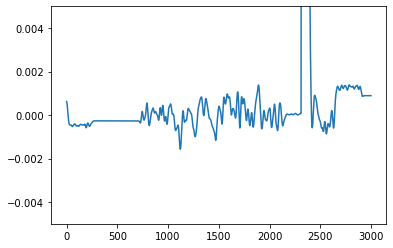

In [37]:
# New
cos_amp_filtered = gaussian_filter(np.mean(cos_amp, axis=0), sigma=8)
plt.plot(cos_amp_filtered)
plt.ylim(-0.005, 0.005)
plt.show()

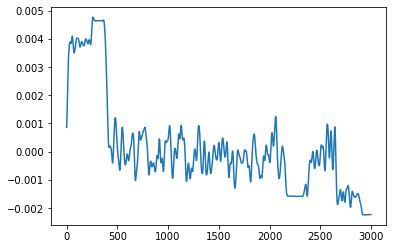

In [10]:
# Old
cos_amp_filtered = gaussian_filter(np.mean(cos_amp, axis=0), sigma=8)
plt.plot(cos_amp_filtered)
plt.show()

In [ ]:
# K-means en dan op memory population

# Er is een probleem met k-means: we hebben te maken met trials * timesteps * channels data, 
# en om k-means te gebruiken moeten die data worden teruggebracht naar twee dimensies, uiteindelijk
# channels * timesteps. Je zou dan het gemiddelde kunnen nemen over alle trials. Maar stel dat in trial 1 
# neuron 100 hevig vuurt voor de bijbehorende angle in de eerste 250 ms, en dat in trial 2 neuron 200
# hevig vuurt voor de angle die daarbij hoort, dan lijkt het gemiddelde voor neuron 100 ontzettend veel
# op dat van neuron 200 (namelijk hoog voor de eerste 250 timesteps). Dus we hebben ofwel een clustering-
# algoritme nodig voor driedimensionale data, ofwel een manier nodig om de data goed te aggregeren.

# Dit is wellicht te ondervangen door niet het gemiddelde te nemen over alle trials, maar over alle
# timesteps. Op die manier worden de activatiepieken niet geconcentreerd in het begin van de timesteps
# over alle channels/neuronen, maar krijg je hevige pieken voor trials en neuronen waar neuronen hevig
# vuurden, en 0 voor trials en neuronen waar neuronen niet werden geactiveerd door de getoonde angle.
# Wel moet je dan na zo'n 500 ms de data afkappen, anders worden de neuronen die vuren voor de impulse
# en de tweede stimulus meegenomen in de aggregatie en krijg je pieken voor trials en neuronen waarbij
# er geen reactie was op de allereerste stimulus.

In [99]:
# K-means (old)
num_channels = 10
neurons = np.mean(sen_data, 0).T # 1000 by 3000
kmeans = KMeans(n_clusters=num_channels, n_init=20, n_jobs=10, tol=1e-20, verbose=2).fit(neurons)

In [4]:
# K-means over trials
cut_data = sen_data[:, :500, :] # 350 by 500 by 1000
num_channels = 10
neurons = np.mean(cut_data, 1).T # 1000 by 350
kmeans = KMeans(n_clusters=num_channels, n_init=20, n_jobs=10, tol=1e-20).fit(neurons)

In [5]:
kmeans.n_iter_

27

In [6]:
# K-means group assignment
data = np.empty((sen_data.shape[0], num_channels, sen_data.shape[1])) # 350 by 10 by 3000
for channel in range(num_channels):
    print(str(channel + 1) + "/" + str(num_channels))
    data[:, channel, :] = np.mean(sen_data[:, :, kmeans.labels_ == channel], axis=2)

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


In [12]:
# Add noise to prevent division by zero errors in covdiag()
data += np.random.normal(scale=0.5, size=(data.shape[0], data.shape[1], data.shape[2]))

In [13]:
# n angles, in degrees
angles = np.load("data/initial_angles_cued4.npy")
# Convert to radians
angles = angles / 360 * 2 * np.pi

bin_width = np.pi / 6
angspace = np.arange(0.5*-np.pi, 0.5*np.pi+bin_width, bin_width)
# angspace = np.arange(-np.pi, 0 + bin_width, bin_width) # [-pi, 0] (inclusive)

if __name__ == '__main__':
    (cos_amp, distances) = wolff.similarity_p(data, angles, angspace, bin_width, num_cores=40)

350


In [9]:
meaned = np.mean(np.mean(sen_data, 0), 1)

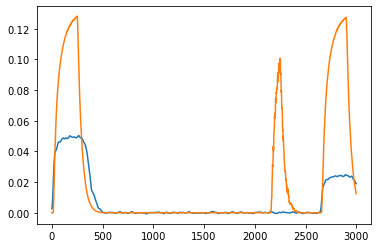

In [14]:
cos_amp_filtered = gaussian_filter(np.mean(cos_amp, axis=0), sigma=8)
# cos_amp_filtered = np.mean(cos_amp, axis=0)
# cos_amp_filtered = gaussian_filter(cos_amp[1], sigma=8)
plt.plot(cos_amp_filtered)
plt.plot(meaned / 30 * 0.14)
plt.show()

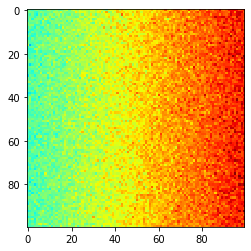

In [12]:
arr = np.random.normal(size=(100, 100))
arr += np.arange(0, 10, 0.1)
plt.imshow(arr, cmap='jet', vmin=-10, vmax=np.max(arr))